In [1]:
using HierarchicalDriving
import POMDPs:initial_state
using POMDPToolbox
using Interact
using MCTS
using AutoViz
import ParticleFilters: obs_weight
import Base: ==, +, *, -, <, >, copy, Random, hash

In [2]:
HORIZON = 13
TIME_STEP = 0.3
lb_x = (AVG_HWY_VELOCITY - 5.0) * TIME_STEP * HORIZON
ub_x = (AVG_HWY_VELOCITY + 5.0) * TIME_STEP * HORIZON
p = LowLevelMDP(0.99,TIME_STEP, HORIZON,
                            HierarchicalDriving.RoadSegment((-100.0, 500.0),[0.0, LANE_WIDTH, 2.0 * LANE_WIDTH, 3.0 * LANE_WIDTH, 4.0 * LANE_WIDTH]),
                            CarPhysicalState((0.0, 3.0 * LANE_WIDTH/2.0, AVG_HWY_VELOCITY)),
                            (CarPhysicalState((lb_x, 5.0 * LANE_WIDTH/2.0 - 0.5, AVG_HWY_VELOCITY - 5)),
                             CarPhysicalState((ub_x, 5.0 * LANE_WIDTH/2.0 + 0.5, AVG_HWY_VELOCITY + 5))),
                            50.0, -500.0, -0.0, -5.0, -5.0, -1.0, HierarchicalDriving.getFrameList());


Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(7, nactions=1),"i",7,"7",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",7=>"7",9=>"9",10=>"10",8=>"8",6=>"6",4=>"4",3=>"3",5=>"5"…)),Any[],Any[],true,"horizontal")

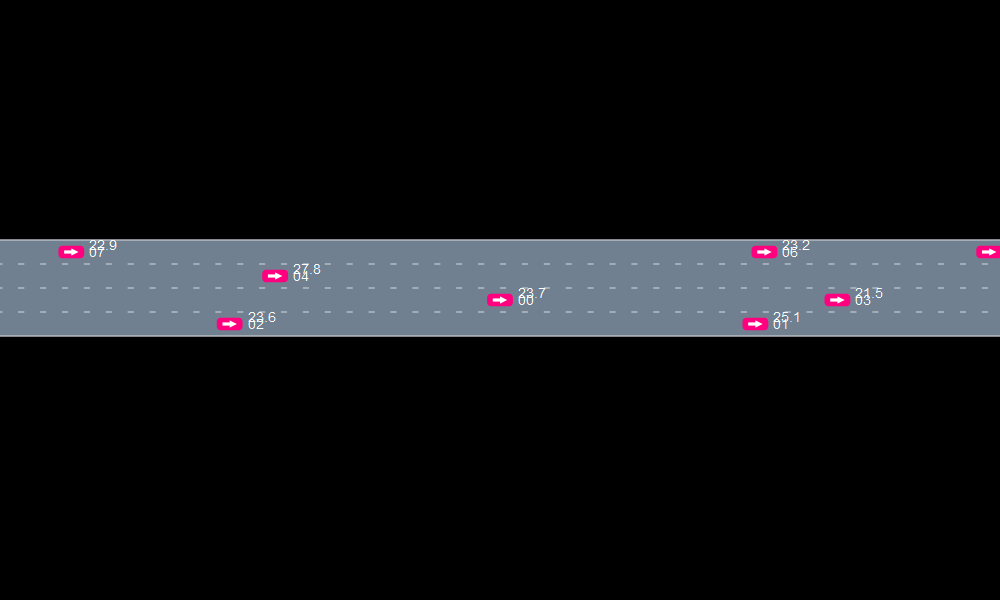

In [18]:
i = 39
#policy = RandomPolicy(p)
policy = subintentional_lowlevel_policy(p);
hr = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i));
hist = simulate(hr, p, policy);
@manipulate for i in 1:n_steps(hist)+1
    (p,state_hist(hist)[i],SceneOverlay[CarVelOverlay(), CarIDOverlay()])
end

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(7, nactions=1),"i",7,"7",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",7=>"7",9=>"9",10=>"10",8=>"8",6=>"6",4=>"4",3=>"3",5=>"5"…)),Any[],Any[],true,"horizontal")

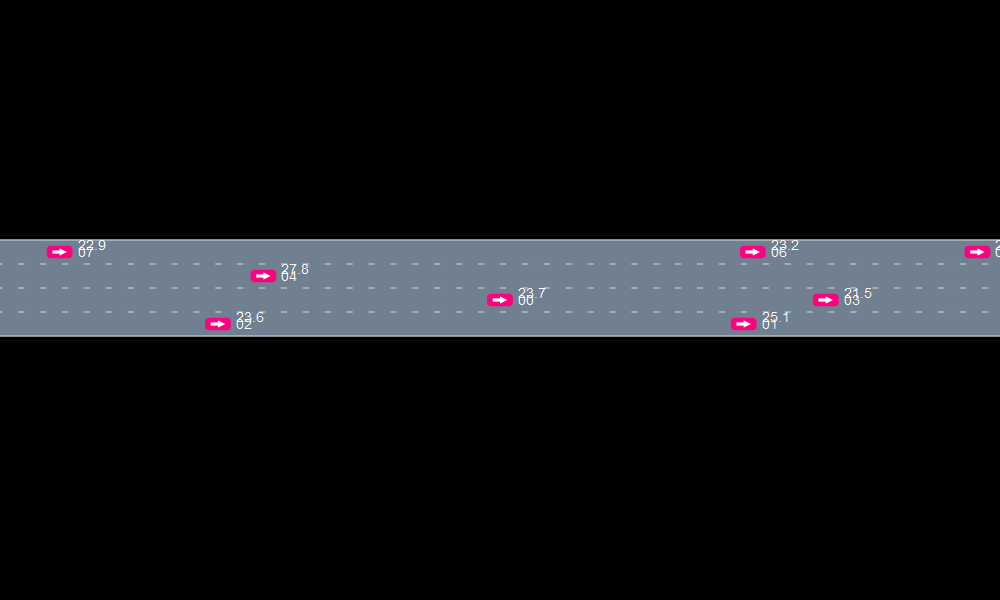

In [19]:
solver = DPWSolver(depth=p.HORIZON,
                           exploration_constant=10.0,
                           n_iterations=1_500,
                           k_action=10.0,
                           alpha_action=1/10,
                           k_state=10.0,
                           alpha_state=1/10,
                            estimate_value=RolloutEstimator(subintentional_lowlevel_policy(p))
                          )
policy1 = solve(solver, p)
hr1 = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
hist1 = simulate(hr1, p, policy1);
@manipulate for i in 1:n_steps(hist1)+1
    (p,state_hist(hist1)[i])
end

In [5]:
sh = state_hist(hist1)[end]
println(sh.ego)

HierarchicalDriving.CarPhysicalState((64.31508314322822,10.199999999999998,26.36390749962482))


In [6]:
discounted_reward(hist)

0.0

In [6]:
discounted_reward(hist1)

34.123558845652454

In [3]:
function testing()
    n = 100
    sum = 0.0
    sum1 = 0.0
    numPositiveRnd = 0
    numPositiveMCTS = 0
    for i in 1:n
        #policy = RandomPolicy(p)
        policy = subintentional_lowlevel_policy(p)
        hr = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
        hist = simulate(hr, p, policy)

        solver = DPWSolver(depth=p.HORIZON,
                               exploration_constant=10.0,
                               n_iterations=1_000,
                               k_action=10.0,
                               alpha_action=1/10,
                               k_state=5.0,
                               alpha_state=1/10,
                               estimate_value=RolloutEstimator(subintentional_lowlevel_policy(p))
                              )
        policy1 = solve(solver, p)
        hr1 = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
        hist1 = simulate(hr1, p, policy1)

        println(i, ",", discounted_reward(hist), ",", discounted_reward(hist1))
        sum += discounted_reward(hist)
        sum1+= discounted_reward(hist1)
        if discounted_reward(hist)>0
            numPositiveRnd += 1
        end
        if discounted_reward(hist1)>0
            numPositiveMCTS += 1
        end
    end
    println("Mean: ",sum/n,",", sum1/n)
    println("Success Rate: ", numPositiveRnd/n, ",", numPositiveMCTS/n)
end

testing (generic function with 1 method)

In [4]:
@time testing()

1,0.0,0.0
2,44.76691271293581,45.21910375044021
3,0.0,44.319243585806454
4,0.0,40.011962463435815
5,44.76691271293581,45.21910375044021
6,0.0,39.319243585806454
7,0.0,44.76691271293581
8,0.0,43.86319366374611
9,44.76691271293581,45.21910375044021
10,44.76691271293581,45.21910375044021
11,0.0,39.319243585806454
12,44.76691271293581,45.21910375044021
13,0.0,44.76691271293581
14,44.76691271293581,45.21910375044021
15,0.0,39.319243585806454
16,44.76691271293581,44.76691271293581
17,44.319243585806454,44.76691271293581
18,44.76691271293581,44.76691271293581
19,0.0,45.21910375044021
20,0.0,34.36924358580646
21,44.76691271293581,44.76691271293581
22,0.0,44.76691271293581
23,44.76691271293581,44.76691271293581
24,44.76691271293581,45.21910375044021
25,0.0,39.319243585806454
26,0.0,34.36924358580646
27,44.76691271293581,44.76691271293581
28,0.0,39.76691271293581
29,44.76691271293581,45.21910375044021
30,44.76691271293581,45.21910375044021
31,0.0,45.21910375044021
32,44.76691271293581,45.2191037